In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
home = os.path.expanduser("~")
import numpy as np
import torch

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plenoptic as po

from ppm.utils import get_checkpoint, get_dataloaders, undo_standardize, PSNR

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.__version__, torch.version.cuda, po.__version__ 
# !conda env list

('2.1.2+cu121', '12.1', '1.0.2')

# Performance

In [4]:
name = '/DAVIS/baselines/C'
C = get_checkpoint(name)

name = '/DAVIS/baselines/cMC'
cMC = get_checkpoint(name)

name = '/DAVIS/baselines/Spyr'
Spyr = get_checkpoint(name)

{'model': 'C', 'filter_size': 17, 'num_channels': 32, 'stride': 1, 'crop': 17, 'memory': 2, 'horizon': 1, 'pad_mode': 'valid', 'branch': 'phase', 'group_size': 2, 'num_quadratics': 6, 'num_scales': 5, 'depth': 3, 'epsilon': 0.0, 'nonlin': 'amplitude', 'skip': 0, 'tied': 1, 'dataset': 'DAVIS', 'image_size': 128, 'num_downs': 1, 'num_crops': 1, 'fold': 2017, 'normalize': 1, 'gray': 1, 'subset': 0, 'transform': 'translate', 'overfit': 0, 'seed': 0, 'train': 0, 'num_epochs': 200, 'mini_batch': 4, 'learning_rate': 0.0003, 'scheduler': 'plateau', 'weight_decay': 0.0, 'max_grad_norm': 0.5, 'output_dir': 'baseline/DAVIS/C', 'log_every': 10, 'viz_pred_dynamics': 0}

 lowest test loss at epoch  0
train:  {'mse': 0.2963218092918396, 'psnr': 21.350990295410156, 'ssim': 0.5780889391899109}
test:  {'mse': 0.3044215440750122, 'psnr': 20.019737243652344, 'ssim': 0.5602179169654846}
Average train time: 0.0m 3.1376354694366455s
Average test time: 0.0m 0.26183581352233887s

{'model': 'cMC', 'filter_size'

In [5]:
# name = '/DAVIS/PP/PP_seed0'
# PP = get_checkpoint(name)

name = '/DAVIS/mPP/mPP_seed0'
mPP = get_checkpoint(name)

name = '/DAVIS/mQP/mQP_seed0'
mQP = get_checkpoint(name)

{'model': 'mPP', 'filter_size': 11, 'num_channels': 16, 'stride': 1, 'crop': 17, 'pad_mode': 'same', 'branch': 'phase', 'group_size': 2, 'num_quadratics': 6, 'num_scales': 4, 'depth': 3, 'epsilon': 1e-10, 'nonlin': 'amplitude', 'skip': 0, 'tied': 1, 'dataset': 'DAVIS', 'image_size': 128, 'num_downs': 1, 'num_crops': 1, 'fold': 2017, 'normalize': 1, 'gray': 1, 'subset': 0, 'transform': 'translate', 'overfit': 0, 'seed': 0, 'train': 1, 'num_epochs': 200, 'mini_batch': 4, 'learning_rate': 0.0003, 'scheduler': 'plateau', 'weight_decay': 0.0, 'max_grad_norm': 0.5, 'output_dir': 'DAVIS/mPP/mPP_seed0', 'log_every': 10, 'viz_pred_dynamics': 0}

 lowest test loss at epoch  160
train:  {'mse': 0.13298584520816803, 'psnr': 25.079490661621094, 'ssim': 0.7274167537689209}
test:  {'mse': 0.13741901516914368, 'psnr': 24.115629196166992, 'ssim': 0.71954745054245}
Average train time: 0m 13s
Average test time: 0m 2s
Number of parameters: 3872
Epoch: 200

{'model': 'mQP', 'filter_size': 11, 'num_channels

In [6]:
name = '/DAVIS/CNN/CNN_seed0/'
CNN = get_checkpoint(name)

name = '/DAVIS/Unet/Unet_seed0'
Unet = get_checkpoint(name)

{'model': 'CNN', 'filter_size': 3, 'num_channels': 64, 'stride': 1, 'crop': 17, 'pad_mode': 'valid', 'branch': 'residual', 'group_size': 2, 'num_quadratics': 6, 'num_scales': 5, 'depth': 20, 'epsilon': 1e-10, 'nonlin': 'relu', 'skip': 0, 'tied': 1, 'dataset': 'DAVIS', 'image_size': 128, 'num_downs': 1, 'num_crops': 1, 'fold': 2017, 'normalize': 1, 'gray': 1, 'subset': 0, 'transform': 'translate', 'overfit': 0, 'seed': 0, 'train': 1, 'num_epochs': 200, 'mini_batch': 4, 'learning_rate': 0.0003, 'scheduler': 'plateau', 'weight_decay': 0.0, 'max_grad_norm': 0.5, 'output_dir': 'DAVIS/CNN/CNN_seed0', 'log_every': 10, 'viz_pred_dynamics': 0}

 lowest test loss at epoch  140
train:  {'mse': 0.11549975723028183, 'psnr': 25.260967254638672, 'ssim': 0.7102402448654175}
test:  {'mse': 0.14767582714557648, 'psnr': 23.56880760192871, 'ssim': 0.6852541565895081}
Average train time: 0m 16s
Average test time: 0m 2s
Number of parameters: 666496
Epoch: 200

{'model': 'Unet', 'filter_size': 17, 'num_chann

In [7]:
def get_performance_stats(names):
    """
    compute mean and std of performance metrics accross multiple runs
    """
    # init dict
    _, train_metrics, test_metrics = get_checkpoint(names[0], verbose=False)
    train_metrics_stats = {key: [value] for key, value in train_metrics.items()}
    test_metrics_stats = {key: [value] for key, value in test_metrics.items()}

    for name in names[1:]:
        _, train_metrics, test_metrics = get_checkpoint(name, verbose=False)
        for key, value in train_metrics.items():
            train_metrics_stats[key].append(value)
        for key, value in test_metrics.items():
            test_metrics_stats[key].append(value)

    R = 2 # rounding precision, number of digits
    for key in train_metrics_stats.keys():
        train_metrics_stats[key] = [
            np.array(train_metrics_stats[key]).mean().round(R), 
            np.array(train_metrics_stats[key]).std().round(R)
        ]
    for key in test_metrics_stats.keys():
        test_metrics_stats[key] = [
            np.array(test_metrics_stats[key]).mean().round(R), 
            np.array(test_metrics_stats[key]).std().round(R)
        ]

    # print('train: ', train_metrics_stats)
    # print('test: ', test_metrics_stats)
    return train_metrics_stats, test_metrics_stats

In [8]:
names = [f'/DAVIS/mPP/mPP_seed{seed}' for seed in range(10)]
get_performance_stats(names)

({'mse': [0.13, 0.0], 'psnr': [25.03, 0.03], 'ssim': [0.73, 0.0]},
 {'mse': [0.14, 0.0], 'psnr': [24.1, 0.02], 'ssim': [0.72, 0.0]})

In [9]:
names = [f'/DAVIS/CNN/CNN_seed{seed}' for seed in range(10)]
get_performance_stats(names)

({'mse': [0.11, 0.01], 'psnr': [25.57, 0.14], 'ssim': [0.72, 0.0]},
 {'mse': [0.15, 0.0], 'psnr': [23.58, 0.06], 'ssim': [0.69, 0.0]})

In [10]:
names = [f'/DAVIS/Unet/Unet_seed{seed}' for seed in range(10)]
get_performance_stats(names)

({'mse': [0.09, 0.01], 'psnr': [25.93, 0.26], 'ssim': [0.73, 0.01]},
 {'mse': [0.14, 0.0], 'psnr': [23.83, 0.06], 'ssim': [0.69, 0.0]})

In [11]:
# TODO visual summary

# methods = [C, cMC, Spyr, PP, mPP, CNN, Unet]
# for i, method in enumerate(methods):
#     plt.bar(i-1/4, method[1]["psnr"], 1/2)
#     plt.bar(i+1/4, method[2]["psnr"], 1/2)
#     print((method[1]["psnr"]).round(2),
#           (method[2]["psnr"]).round(2))

# plt.ylabel("psnr train/test")
# plt.xticks(range(len(methods)),
#            ['C', 'cMC', 'Spyr', 'PP', 'mPP', 'CNN', 'Unet'])
# plt.show()

# import seaborn as sns
# import pandas as pd
# d = {'name': [],
#      'method': [],
#      'mse': [],
#      'psnr': [],
#      'ssim': [],
#      'split': [],
#      }
# df = pd.DataFrame(data=d)
# performance = pd.DataFrame()
# sns.barplot(performance, x="method", y="psnr", hue="split")

# Examples

In [12]:
train_dataloader, test_dataloader, data_stats = get_dataloaders(
    batch_size=4, name='DAVIS', subset=0
)

Loading DAVIS dataset
data path  /mnt/home/pfiquet/Documents/datasets/DAVIS/npySnips/128pixels_1levels_01crops_gray
caching train clips data


100%|████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.43it/s]


data path  /mnt/home/pfiquet/Documents/datasets/DAVIS/npySnips/128pixels_1levels_01crops_gray
caching val clips data


100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.93it/s]


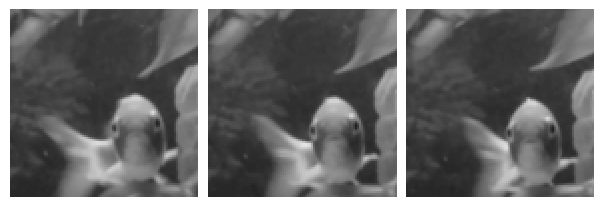

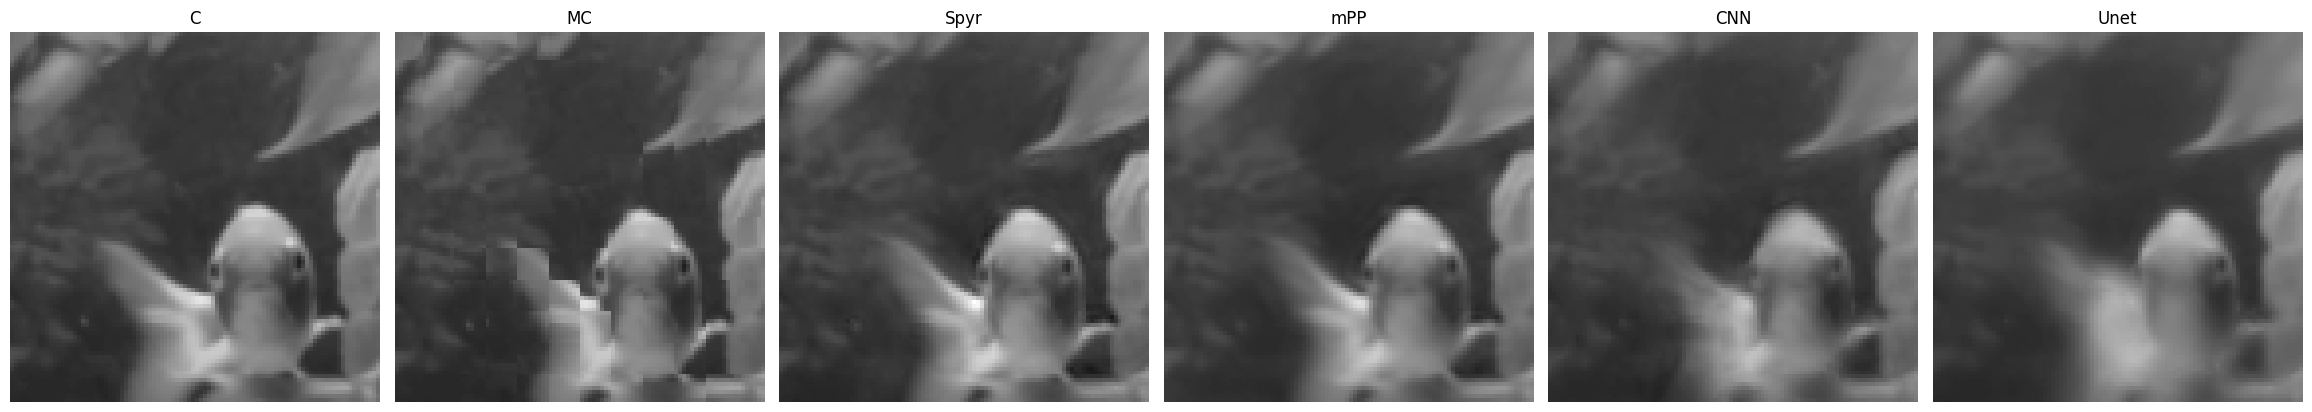

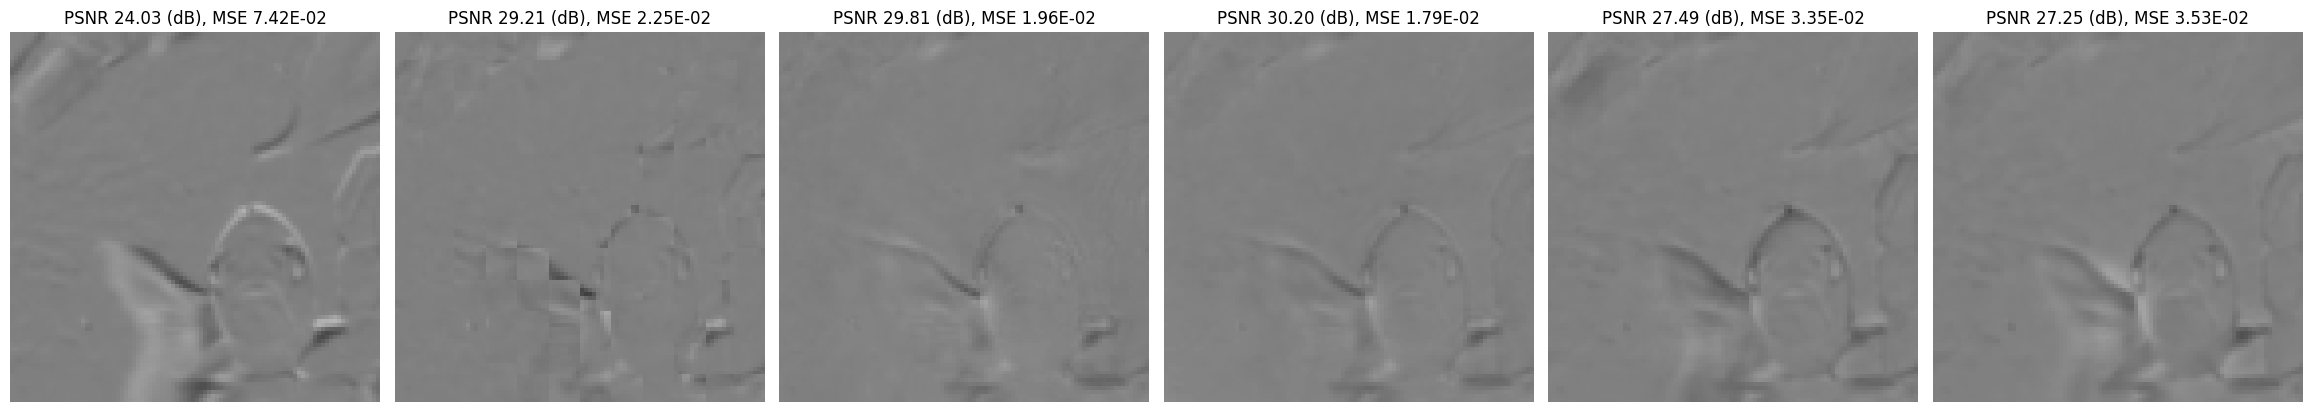

In [13]:
# eval models on example test image
i = 142
t = 4

x = test_dataloader.dataset[i].unsqueeze(0).to(DEVICE)
x_star, x_hat = Unet[0].predict(x)

x_s = undo_standardize(x_star, data_stats)
po.imshow(x_s[0, :, t:t+3].cpu(), vrange=[0, 1], title=None, zoom=2);
plt.show()

models = [C, cMC, Spyr, mPP, CNN, Unet] # mQP
fig, axes = plt.subplots(1, len(models), figsize=(len(models) * 4, 4))
fig_err, axes_err = plt.subplots(1, len(models), figsize=(len(models) * 4, 4))

for i, M in enumerate(models):
    x_star, x_hat = M[0].predict(x)
    psnr = PSNR(x_star, x_hat, data_stats)[0, t+2:t+3].item()
    mse = (x_star - x_hat)[0, :, t+2:t+3].pow(2).mean().item()

    x_h = undo_standardize(x_hat, data_stats)

    po.imshow(x_h.cpu()[0, :, t+2:t+3], vrange=[0, 1], title=None, zoom=2, ax=axes[i]);
    axes[i].set_title(type(M[0]).__name__)
    axes[i].axis('off')
    po.imshow((x_h.cpu() - x_s.cpu())[0, :, t+2:t+3], vrange=[-1, 1], title=None, zoom=2, ax=axes_err[i]);
    axes_err[i].set_title(f"PSNR {psnr:.2f} (dB), MSE {mse:.2E}")
    axes_err[i].axis('off')

fig.tight_layout()
fig.show()

fig_err.tight_layout()
fig_err.show()